asdasd




In [17]:
import itertools
import os
import pickle
import pandas as pd
from deap import creator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [2]:


def parse_file(path):
    data = []
    with open(path, 'r') as f:
        lines = f.readlines()
        opt = int(lines[0].replace('optimum=', ''))
        time = float(lines[1].split(',')[0].replace('execution_time=', ''))
        trace = []
        for idx,f in enumerate(lines[3:]):
            parts = f.split(',')
            fitness = int(float(parts[0].replace('fitness=', '')))
            iteration = int(float(parts[1].replace('iteration=', '')))
            gap = float(parts[2].replace('gap=', ''))
            delta = int(float(parts[3].replace('delta=', '')))
            timestamp = float(parts[4].replace('timestamp=', ''))
            data.append((idx, opt, time, fitness, iteration, gap, delta, timestamp))
    return data

In [3]:
def load_full_experiment(path, algs, ns, runs, ls):
    data = []
    for alg, n in list(itertools.product(algs, ns)):
        for i in runs:
            filename = path + "result_{}_{}_{}_{}.txt".format(alg, n, i, ls)
            dat = parse_file(filename)
            data = data + [(alg,n,i)+d for d in dat]

    return data


def load_ga_aco_dnala(path, ls):
    algs = ["ga", "aco", "dnala"]
    ns = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
    basepath = path
    runs = range(0, 5)
    data = load_full_experiment(basepath, algs, ns, runs, ls)

    df = pd.DataFrame(data=data, columns=['alg','n','i','idx','optimum', 'time', 'fitness', 'iteration', 'gap', 'delta', 'timestamp'])
    df = df.set_index(['alg','n','i','idx'])

    df = df.groupby(by=['alg','n','i']).apply(lambda x: x.sort_values(['idx'], ascending=True)).groupby(by=['alg','n','i']).tail(1).groupby(by=['alg','n']).median()

    df['time'] = np.minimum(np.floor(df['time']),300)
    df = df.drop(columns=['timestamp','delta'])
    return df

print('NO-LocalSearch')
without_ls = load_ga_aco_dnala('./output/results_nols/', False)

#print('WITH-LocalSearch 100BF')
#load_ga_aco_dnala('./output/results_100-ls/', True)

print('WITH-LocalSearch 50FF')
with_ls = load_ga_aco_dnala('./output/results_50-ff-ls/', True)

with_ls.drop(columns='optimum',inplace=True)

without_ls = without_ls[['optimum','fitness','gap','time','iteration']]
with_ls = with_ls[['fitness','gap','time','iteration']]

main_table = pd.concat([without_ls, with_ls], axis=1)

print(main_table.to_latex(float_format="%.2f"))

#main_table.drop(columns=['optimum'], inplace=True)
#print(main_table)


NO-LocalSearch
WITH-LocalSearch 50FF
\begin{tabular}{llrrrrrrrrr}
\toprule
   &     &  optimum &  fitness &    gap &   time &  iteration &  fitness &   gap &   time &  iteration \\
alg & n &          &          &        &        &            &          &       &        &            \\
\midrule
aco & 10  &     1994 &     1994 &   0.00 &   0.00 &          0 &     1994 &  0.00 &   0.00 &          0 \\
   & 20  &    11758 &    11758 &   0.00 &   0.00 &          0 &    11758 &  0.00 &   0.00 &          0 \\
   & 30  &    19032 &    19032 &   0.00 &   0.00 &          2 &    19032 &  0.00 &   0.00 &          0 \\
   & 40  &    20892 &    20892 &   0.00 &  10.00 &         88 &    20892 &  0.00 &   0.00 &          0 \\
   & 50  &    34198 &    34320 &   0.36 & 300.00 &        280 &    34198 &  0.00 &   1.00 &          0 \\
   & 60  &    42382 &    44310 &   4.55 & 300.00 &        317 &    42382 &  0.00 &   2.00 &          0 \\
   & 70  &    47234 &    51766 &   9.59 & 300.00 &        623 &    4

       n  i  population_size  idx  optimum        time  fitness  iteration  \
0     50  0               20    0    34198  300.019236    45838          0   
1     50  0               20    1    34198  300.019236    45542          1   
2     50  0               20    2    34198  300.019236    44740          2   
3     50  0               20    3    34198  300.019236    37834          3   
4     50  0               20    4    34198  300.019236    35564          6   
..   ... ..              ...  ...      ...         ...      ...        ...   
218  100  3              500    2    83495  300.736657   115263          7   
219  100  3              500    3    83495  300.736657   115205         13   
220  100  3              500    4    83495  300.736657   114437         16   
221  100  3              500    5    83495  300.736657   113349         24   
222  100  3              500    6    83495  300.736657   112933         64   

           gap  delta   timestamp  
0    34.037078  11640    1.

optimum   time   fitness  iteration        gap
population_size n                                                  
20              50   34198.0   12.0   34198.0     1067.0   0.000000
                100  83495.0  300.0  133500.0      905.5  59.889814
100             50   34198.0   21.0   34198.0      373.5   0.000000
                100  83495.0  300.0  100911.0      445.0  20.858734
300             50   34198.0   69.0   34198.0      112.0   0.000000
                100  83495.0  300.0   90189.0      324.0   8.017247
500             50   34198.0   21.0   34198.0       84.0   0.000000
                100  83495.0  300.0   90327.0      235.0   8.182526

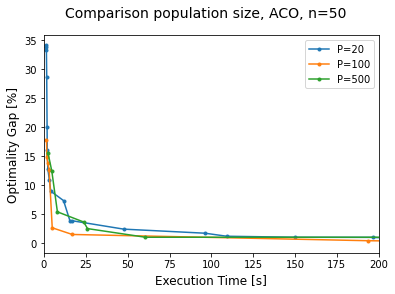

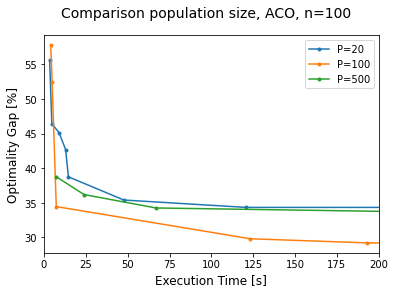

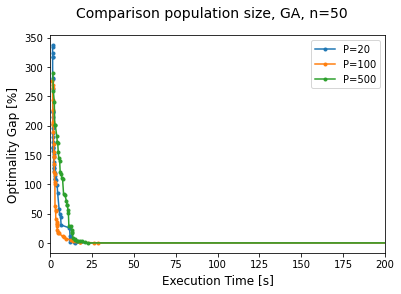

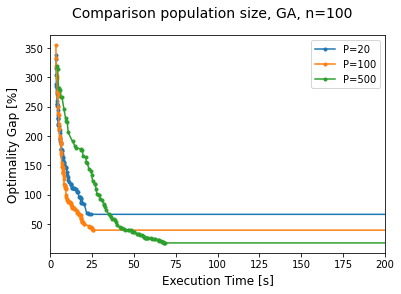

In [68]:
def load_ga_population_comparison_full_experiment(path, ns, runs, population_sizes,alg):
    data = []
    for population_size, n in list(itertools.product(population_sizes, ns)):
        for i in runs:
            filename = path + "result_{}_{}_{}_{}.txt".format(n,alg,population_size, i)
            if not os.path.exists(filename):
                continue
            dat = parse_file(filename)
            data = data + [(n,i,population_size)+d for d in dat]

    return data

In [ ]:
def load_population_comparison(path,instance_size,instance,convergence,alg):
    ns = [50,100]
    population_sizes = [20,100,300, 500]
    basepath = path
    runs = range(0, 4)
    data = load_ga_population_comparison_full_experiment(basepath, ns, runs, population_sizes,alg)

    raw = pd.DataFrame(data=data, columns=['n','i','population_size','idx','optimum', 'time', 'fitness', 'iteration', 'gap', 'delta', 'timestamp'])

    df = raw.set_index(['n','i','population_size','idx'])

    df = df.groupby(by=['population_size','n','i']).apply(lambda x: x.sort_values(['idx'], ascending=True)).groupby(by=['population_size','n','i']).tail(1).groupby(by=['population_size','n']).median()

    df['time'] = np.minimum(np.floor(df['time']),300)
    df = df.drop(columns=['timestamp','delta'])

    pg = raw.drop(columns=['iteration', 'idx','delta','fitness','time'])

    # df2 = raw.groupby(by=['population_size','n','i'])


    pop_50 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.population_size == 20)][['gap','timestamp']]
    pop_100 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.population_size == 100)][['gap','timestamp']]
    pop_300 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.population_size == 500)][['gap','timestamp']]

    pop_50 = pd.concat([pop_50, pd.DataFrame(data=[(pop_50['gap'].min(), convergence+100)], columns=['gap','timestamp'])])
    pop_100 = pd.concat([pop_100, pd.DataFrame(data=[(pop_100['gap'].min(), convergence+100)], columns=['gap','timestamp'])])
    pop_300 = pd.concat([pop_300, pd.DataFrame(data=[(pop_300['gap'].min(), convergence+100)], columns=['gap','timestamp'])])

    fig = plt.figure()
    fig.add_subplot(1,1,1)

    plt.plot(pop_50['timestamp'],pop_50['gap'], label='P=20', marker='.')
    plt.plot(pop_100['timestamp'],pop_100['gap'], label='P=100', marker='.')
    plt.plot(pop_300['timestamp'],pop_300['gap'], label='P=500', marker='.')
    plt.legend(loc='best')

    plt.xlabel('Execution Time [s]', fontsize=12)
    plt.ylabel('Optimality Gap [%]', fontsize=12)
    plt.xlim((0, convergence))

    plt.suptitle('Comparison population size, {}, n={}'.format(alg.upper(),instance_size), fontsize=14)

    plt.savefig('{}_{}_population_comparison.pdf'.format(alg,instance_size),bbox_inches='tight')

    # print(pop_50)
    # print(pop_100)
    # print(pop_300)

    return df


# load_ga_population_comparison('./output/ga_population_comparison/',instance_size = 100,instance = 1,convergence = 100)
load_population_comparison('./output/aco_population_comparison/',instance_size = 50, instance = 1,convergence = 200, alg='aco')
load_population_comparison('./output/aco_population_comparison/',instance_size = 100, instance = 1,convergence = 200, alg='aco')
load_population_comparison('./output/ga_population_comparison/',instance_size = 50, instance = 1,convergence = 200, alg='ga')
load_population_comparison('./output/ga_population_comparison/',instance_size = 100, instance = 1,convergence = 200, alg='ga')


,,optimum,time,fitness,iteration,gap
mutation_rate,n,,,,,
1,50,34198.0,300.0,34743.0,154.0,1.593660
4,50,34198.0,283.0,34198.0,1349.5,0.000000
8,50,34198.0,300.0,42317.0,41.5,23.741154


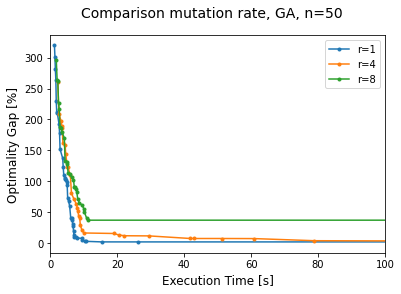

In [82]:

def load_ga_mutation_rate_comparison_full_experiment(path, ns, runs, mr,alg):
    data = []
    for mutation_rate, n in list(itertools.product(mr, ns)):
        for i in runs:
            filename = path + "result_{}_{}_{}_{}.txt".format(n,alg,mutation_rate, i)
            if not os.path.exists(filename):
                continue
            dat = parse_file(filename)
            data = data + [(n,i,mutation_rate)+d for d in dat]

    return data

def load_mutation_rate_comparison(path,instance_size,instance,convergence,alg):
    mr = [1,4,8]
    ns = [50,100]
    basepath = path
    runs = range(0, 4)
    data = load_ga_mutation_rate_comparison_full_experiment(basepath, ns, runs, mr,alg)

    raw = pd.DataFrame(data=data, columns=['n','i','mutation_rate','idx','optimum', 'time', 'fitness', 'iteration', 'gap', 'delta', 'timestamp'])

    df = raw.set_index(['n','i','mutation_rate','idx'])

    df = df.groupby(by=['mutation_rate','n','i']).apply(lambda x: x.sort_values(['idx'], ascending=True)).groupby(by=['mutation_rate','n','i']).tail(1).groupby(by=['mutation_rate','n']).median()

    df['time'] = np.minimum(np.floor(df['time']),300)
    df = df.drop(columns=['timestamp','delta'])

    pg = raw.drop(columns=['iteration', 'idx','delta','fitness','time'])

    # df2 = raw.groupby(by=['population_size','n','i'])


    pop_50 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.mutation_rate == 1)][['gap','timestamp']]
    pop_100 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.mutation_rate == 4)][['gap','timestamp']]
    pop_300 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.mutation_rate == 8)][['gap','timestamp']]

    pop_50 = pd.concat([pop_50, pd.DataFrame(data=[(pop_50['gap'].min(), convergence+100)], columns=['gap','timestamp'])])
    pop_100 = pd.concat([pop_100, pd.DataFrame(data=[(pop_100['gap'].min(), convergence+100)], columns=['gap','timestamp'])])
    pop_300 = pd.concat([pop_300, pd.DataFrame(data=[(pop_300['gap'].min(), convergence+100)], columns=['gap','timestamp'])])

    fig = plt.figure()
    fig.add_subplot(1,1,1)

    plt.plot(pop_50['timestamp'],pop_50['gap'], label='r=1', marker='.')
    plt.plot(pop_100['timestamp'],pop_100['gap'], label='r=4', marker='.')
    plt.plot(pop_300['timestamp'],pop_300['gap'], label='r=8', marker='.')
    plt.legend(loc='best')

    plt.xlabel('Execution Time [s]', fontsize=12)
    plt.ylabel('Optimality Gap [%]', fontsize=12)
    plt.xlim((0, convergence))

    plt.suptitle('Comparison mutation rate, {}, n={}'.format(alg.upper(),instance_size), fontsize=14)

    plt.savefig('{}_{}_mutation_rate_comparison.pdf'.format(alg,instance_size),bbox_inches='tight')

    # print(pop_50)
    # print(pop_100)
    # print(pop_300)

    return df


load_mutation_rate_comparison('./output/ga_mutation_rate_comparison/', instance_size = 50, instance = 1,convergence = 100, alg='ga')


      n  i  alpha  beta  idx  optimum        time  fitness  iteration  \
0    50  0      1     1    0    34198  300.208529    68050          0   
1    50  0      1     1    1    34198  300.208529    65214          1   
2    50  0      1     1    2    34198  300.208529    60980          2   
3    50  0      1     1    3    34198  300.208529    59948         13   
4    50  0      1     1    4    34198  300.208529    56508         17   
..   .. ..    ...   ...  ...      ...         ...      ...        ...   
246  50  3      8     8    0    34198   60.266138    34532          0   
247  50  3      8     8    1    34198   60.266138    34524          1   
248  50  3      8     8    2    34198   60.266138    34254          4   
249  50  3      8     8    3    34198   60.266138    34206         74   
250  50  3      8     8    4    34198   60.266138    34198        261   

           gap  delta  timestamp  
0    98.988245  33852   1.510920  
1    90.695362  31016   1.732804  
2    78.314521  26

optimum   time  fitness  iteration        gap
alpha beta n                                                
1     1    50  34198.0  300.0  47329.0      359.0  38.396982
      4    50  34198.0  169.0  34198.0      727.0   0.000000
      8    50  34198.0    5.0  34198.0       25.0   0.000000
4     1    50  34198.0  300.0  45703.0      844.5  33.642318
      4    50  34198.0  265.0  34202.0      626.0   0.011697
      8    50  34198.0   27.0  34198.0      118.0   0.000000
8     1    50  34198.0  300.0  49232.0      823.5  43.961635
      4    50  34198.0  213.0  34198.0      743.5   0.000000
      8    50  34198.0   45.0  34198.0      199.5   0.000000

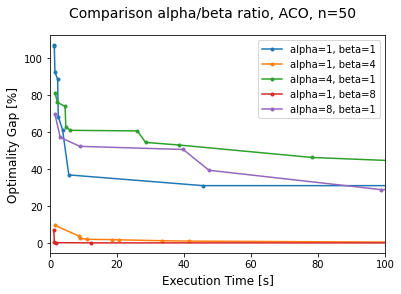

In [89]:


def load_aco_params_comparison_full_experiment(path, ns, runs, alphas,betas,alg):
    data = []
    for alpha,beta, n in list(itertools.product(alphas, betas, ns)):
        for i in runs:
            filename = path + "result_{}_{}_{}_{}_{}.txt".format(n,alg,alpha,beta, i)
            if not os.path.exists(filename):
                continue
            dat = parse_file(filename)
            data = data + [(n,i,alpha,beta)+d for d in dat]

    return data

def load_aco_params_comparison(path,instance_size,instance,convergence,alg):
    alphas = [1,4,8]
    betas = [1,4,8]
    ns = [50,100]
    basepath = path
    runs = range(0, 4)
    data = load_aco_params_comparison_full_experiment(basepath, ns, runs, alphas,betas,alg)

    raw = pd.DataFrame(data=data, columns=['n','i','alpha','beta','idx','optimum', 'time', 'fitness', 'iteration', 'gap', 'delta', 'timestamp'])
    print(raw)
    df = raw.set_index(['n','i','alpha','beta','idx'])

    df = df.groupby(by=['alpha','beta','n','i']).apply(lambda x: x.sort_values(['idx'], ascending=True)).groupby(by=['alpha','beta','n','i']).tail(1).groupby(by=['alpha','beta','n']).median()

    df['time'] = np.minimum(np.floor(df['time']),300)
    df = df.drop(columns=['timestamp','delta'])

    pg = raw.drop(columns=['iteration', 'idx','delta','fitness','time'])

    # df2 = raw.groupby(by=['population_size','n','i'])


    p11 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.alpha == 1)& (pg.beta == 1)][['gap','timestamp']]
    p14 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.alpha == 1)& (pg.beta == 4)][['gap','timestamp']]
    p41 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.alpha == 4)& (pg.beta == 1)][['gap','timestamp']]
    p18 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.alpha == 1)& (pg.beta == 8)][['gap','timestamp']]
    p81 = pg[(pg.i == instance) & (pg.n == instance_size) & (pg.alpha == 8)& (pg.beta == 1)][['gap','timestamp']]

    p11 = pd.concat([p11, pd.DataFrame(data=[(p11['gap'].min(), convergence+100)], columns=['gap','timestamp'])])
    p14 = pd.concat([p14, pd.DataFrame(data=[(p14['gap'].min(), convergence+100)], columns=['gap','timestamp'])])
    p41 = pd.concat([p41, pd.DataFrame(data=[(p41['gap'].min(), convergence+100)], columns=['gap','timestamp'])])
    p18 = pd.concat([p18, pd.DataFrame(data=[(p18['gap'].min(), convergence+100)], columns=['gap','timestamp'])])
    p81 = pd.concat([p81, pd.DataFrame(data=[(p81['gap'].min(), convergence+100)], columns=['gap','timestamp'])])

    fig = plt.figure()
    fig.add_subplot(1,1,1)

    plt.plot(p11['timestamp'],p11['gap'], label='alpha=1, beta=1', marker='.')
    plt.plot(p14['timestamp'],p14['gap'], label='alpha=1, beta=4', marker='.')
    plt.plot(p41['timestamp'],p41['gap'], label='alpha=4, beta=1', marker='.')
    plt.plot(p18['timestamp'],p18['gap'], label='alpha=1, beta=8', marker='.')
    plt.plot(p81['timestamp'],p81['gap'], label='alpha=8, beta=1', marker='.')
    plt.legend(loc='best')

    plt.xlabel('Execution Time [s]', fontsize=12)
    plt.ylabel('Optimality Gap [%]', fontsize=12)
    plt.xlim((0, convergence))

    plt.suptitle('Comparison alpha/beta ratio, {}, n={}'.format(alg.upper(),instance_size), fontsize=14)

    plt.savefig('{}_{}_alpha_beta_ratio_comparison.pdf'.format(alg,instance_size),bbox_inches='tight')

    # print(pop_50)
    # print(pop_100)
    # print(pop_300)

    return df

load_aco_params_comparison('./output/aco_alpha_beta_comparison/', instance_size = 50, instance = 1,convergence = 100, alg='aco')